# ELM

## Importing Libraries

In [1]:
import torch
import time
import pandas as pd
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Dateset Class and DataLoader

In [2]:
class ELM_Dataset(Dataset):
    def __init__(self, features, labels):
        super(ELM_Dataset, self).__init__()

        self.features = torch.Tensor(features, dtype = torch.float32)
        self.labels = torch.Tensor(labels, dtype = torch.float32)

    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index):
        feature = self.features[index]
        label = self.labels[index]

        return feature, label

## ELM Class

In [3]:
class ELM(nn.Module):
    def __init__(self, n_hidden_neurons, device = 'cuda', chunk_size = 100):
        super(ELM, self).__init__()

        self.n_hidden_neurons = n_hidden_neurons
        self.device = device
        self.chunk_size = chunk_size
        self.input_weights = None
        self.biases = None
        self.output_weights = None

    def fit(self, X, y, regularization = 1e-8):
        
        X = X.to(self.device)
        y = y.to(self.device).view(-1, 1)
        
        n_samples, n_features = X.shape

        self.input_weights = torch.randn(n_features, self.n_hidden_neurons, device = self.device, dtype = torch.float32)
        self.biases = torch.randn(1, self.n_hidden_neurons, device = self.device, dtype = torch.float32)

        # Check if we need micro-batching based on memory requirements
        if torch.cuda.is_available():
            available_mem = torch.cuda.get_device_properties(0).total_memory / 1e9
            required_mem = n_samples * self.n_hidden_neurons * 4 / 1e9  # 4 bytes per float32
            
            if required_mem > available_mem * 0.6:  # Use micro-batching if H matrix > 60% of GPU memory
                print(f"Large matrix detected ({required_mem:.1f} GB). Using micro-batching...")
                return self._fit_micro_batched(X, y, regularization)
        
        # Standard ELM computation
        try:
            H = torch.sigmoid(X @ self.input_weights + self.biases)
            HTH = H.T @ H
            HTy = H.T @ y
        except torch.cuda.OutOfMemoryError:
            print("GPU out of memory. Switching to micro-batching...")
            torch.cuda.empty_cache()
            return self._fit_micro_batched(X, y, regularization)

        I = torch.eye(self.n_hidden_neurons, device=self.device)
        self.output_weights = torch.linalg.solve(HTH + regularization * I, HTy)

    def _fit_micro_batched(self, X, y, regularization):
        """Micro-batching to handle large matrices"""
        n_samples = X.shape[0]
        
        # Initialize accumulator matrices
        HTH = torch.zeros(self.n_hidden_neurons, self.n_hidden_neurons, device=self.device, dtype=torch.float32)
        HTy = torch.zeros(self.n_hidden_neurons, 1, device=self.device, dtype=torch.float32)
        
        # Process in small chunks
        for i in range(0, n_samples, self.chunk_size):
            end_idx = min(i + self.chunk_size, n_samples)
            X_chunk = X[i:end_idx]
            y_chunk = y[i:end_idx]
            
            # Compute hidden layer for chunk
            H_chunk = torch.sigmoid(X_chunk @ self.input_weights + self.biases)
            
            # Accumulate HTH and HTy
            HTH += H_chunk.T @ H_chunk
            HTy += H_chunk.T @ y_chunk
            
            # Clear chunk from memory
            del H_chunk
            
        # Solve for output weights using accumulated matrices
        I = torch.eye(self.n_hidden_neurons, device=self.device)
        self.output_weights = torch.linalg.solve(HTH + regularization * I, HTy)

    def predict(self, X):

        X = X.to(self.device)
        n_samples = X.shape[0]
        
        # Use micro-batching for prediction if needed
        if n_samples > self.chunk_size * 2:  # Use chunking for large prediction sets
            predictions_list = []
            
            for i in range(0, n_samples, self.chunk_size):
                end_idx = min(i + self.chunk_size, n_samples)
                X_chunk = X[i:end_idx]
                
                H_chunk = torch.sigmoid(X_chunk @ self.input_weights + self.biases)
                pred_chunk = H_chunk @ self.output_weights
                predictions_list.append((pred_chunk > 0.5).int().flatten())
                
                del H_chunk, pred_chunk
            
            return torch.cat(predictions_list, dim=0)
        
        # Standard prediction
        H = torch.sigmoid(X @ self.input_weights + self.biases)
        predictions = H @ self.output_weights

        return (predictions > 0.5).int().flatten()

## Initialization and Model Training

Master script started. Using device: cuda

--- Starting Tuning for MEFAR_DOWN.csv ---
  Neurons:   150 | Accuracy:  65.72% | Time: 0.19s
  Neurons:   250 | Accuracy:  66.87% | Time: 0.00s
  Neurons:   500 | Accuracy:  69.46% | Time: 0.01s
  Neurons:  1000 | Accuracy:  71.35% | Time: 0.02s
  Neurons:  1500 | Accuracy:  73.01% | Time: 0.03s
  Neurons:  2000 | Accuracy:  72.69% | Time: 0.04s
  Neurons:  5000 | Accuracy:  74.01% | Time: 0.17s
  Neurons:  8000 | Accuracy:  71.31% | Time: 0.29s
  Neurons: 10000 | Accuracy:  71.06% | Time: 0.45s
  Neurons: 15000 | Accuracy:  66.43% | Time: 1.02s
  Neurons: 20000 | Accuracy:  49.58% | Time: 1.98s
  Neurons: 25000 | Accuracy:  50.51% | Time: 133.98s
  Neurons: 30000 | Accuracy:  48.88% | Time: 208.35s


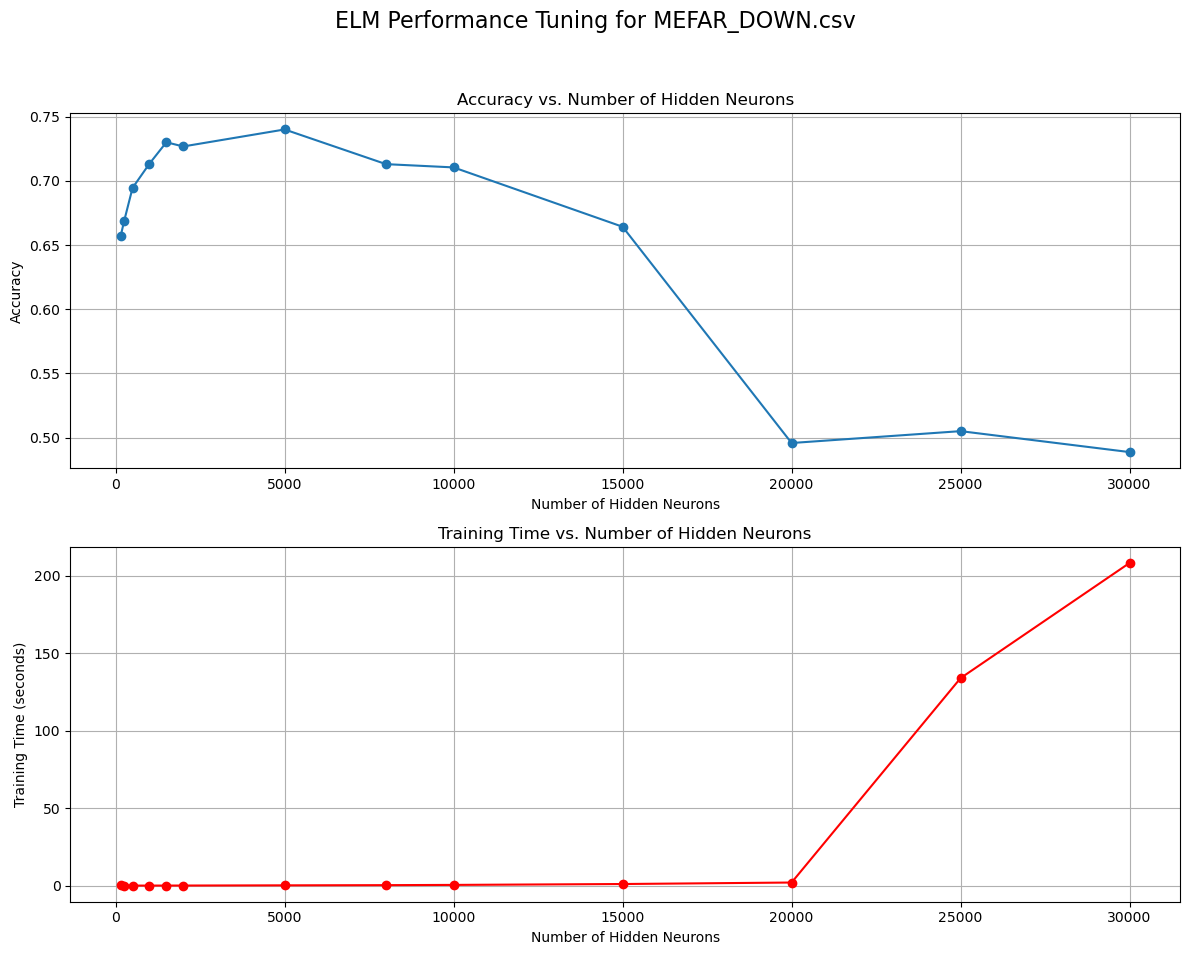

--- Finished Tuning for MEFAR_DOWN.csv ---

--- Starting Tuning for MEFAR_MID.csv ---
  Neurons:   150 | Accuracy:  66.70% | Time: 0.26s
  Neurons:   250 | Accuracy:  69.34% | Time: 0.08s
  Neurons:   500 | Accuracy:  71.23% | Time: 0.14s
  Neurons:  1000 | Accuracy:  74.50% | Time: 0.30s
  Neurons:  1500 | Accuracy:  77.14% | Time: 0.87s
Large matrix detected (5.9 GB). Using micro-batching...
  Neurons:  2000 | Accuracy:  78.37% | Time: 1.23s
Large matrix detected (14.8 GB). Using micro-batching...
  Neurons:  5000 | Accuracy:  83.41% | Time: 13.14s
Large matrix detected (23.6 GB). Using micro-batching...
  Neurons:  8000 | Accuracy:  86.80% | Time: 33.41s
Large matrix detected (29.5 GB). Using micro-batching...
  Neurons: 10000 | Accuracy:  88.71% | Time: 52.34s
Large matrix detected (44.3 GB). Using micro-batching...
  Neurons: 15000 | Accuracy:  92.08% | Time: 117.67s
Large matrix detected (59.1 GB). Using micro-batching...
  Neurons: 20000 | Accuracy:  94.56% | Time: 209.47s
Large

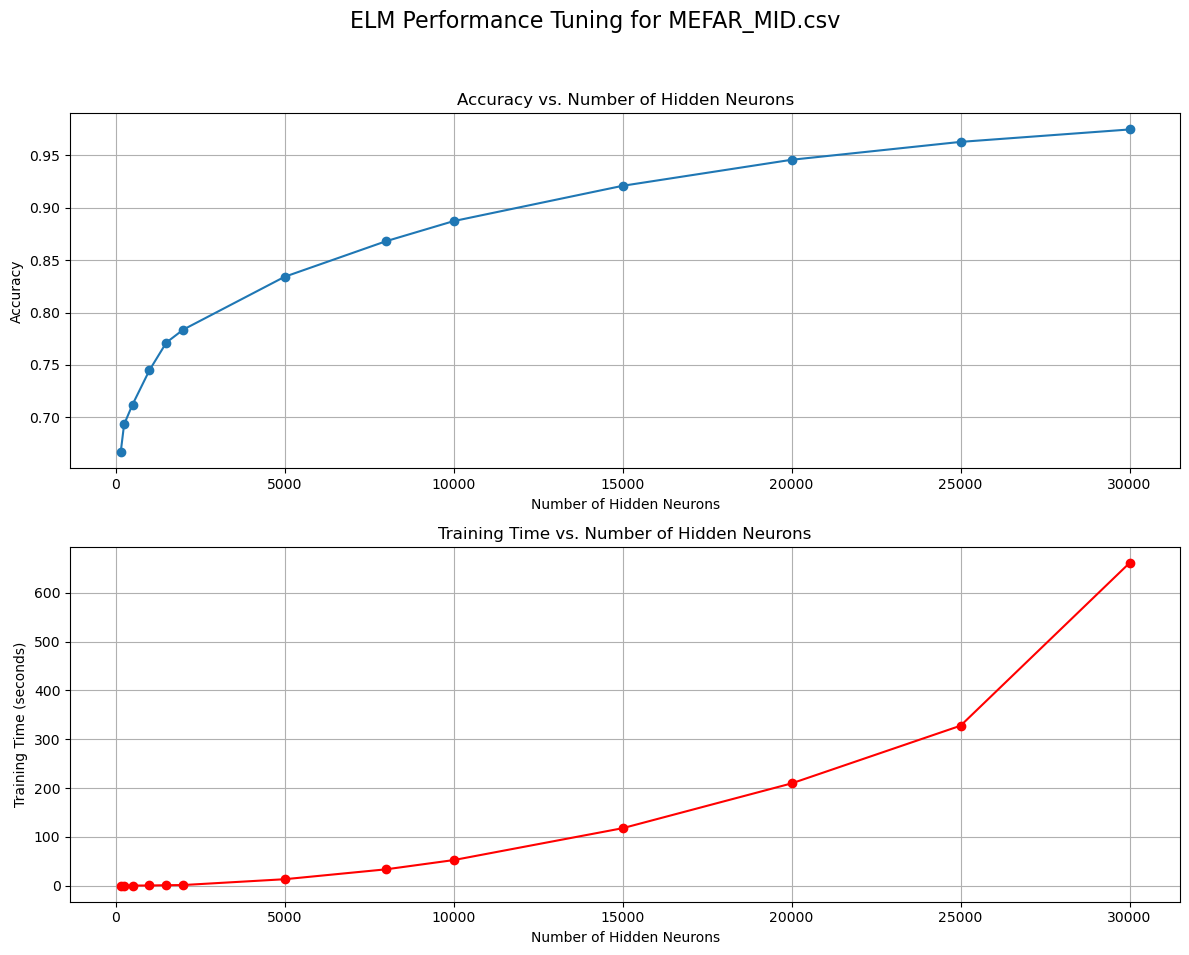

--- Finished Tuning for MEFAR_MID.csv ---

--- Starting Tuning for MEFAR_UP.csv ---
  Neurons:   150 | Accuracy:  66.67% | Time: 0.20s
  Neurons:   250 | Accuracy:  67.89% | Time: 0.15s
  Neurons:   500 | Accuracy:  70.47% | Time: 0.26s
Large matrix detected (5.9 GB). Using micro-batching...
  Neurons:  1000 | Accuracy:  74.68% | Time: 1.70s
Large matrix detected (8.9 GB). Using micro-batching...
  Neurons:  1500 | Accuracy:  76.88% | Time: 1.68s
Large matrix detected (11.8 GB). Using micro-batching...
  Neurons:  2000 | Accuracy:  77.53% | Time: 2.41s
Large matrix detected (29.5 GB). Using micro-batching...
  Neurons:  5000 | Accuracy:  83.55% | Time: 26.22s
Large matrix detected (47.3 GB). Using micro-batching...
  Neurons:  8000 | Accuracy:  86.32% | Time: 66.90s
Large matrix detected (59.1 GB). Using micro-batching...
  Neurons: 10000 | Accuracy:  88.22% | Time: 104.61s
Large matrix detected (88.6 GB). Using micro-batching...
  Neurons: 15000 | Accuracy:  91.56% | Time: 234.56s
Lar

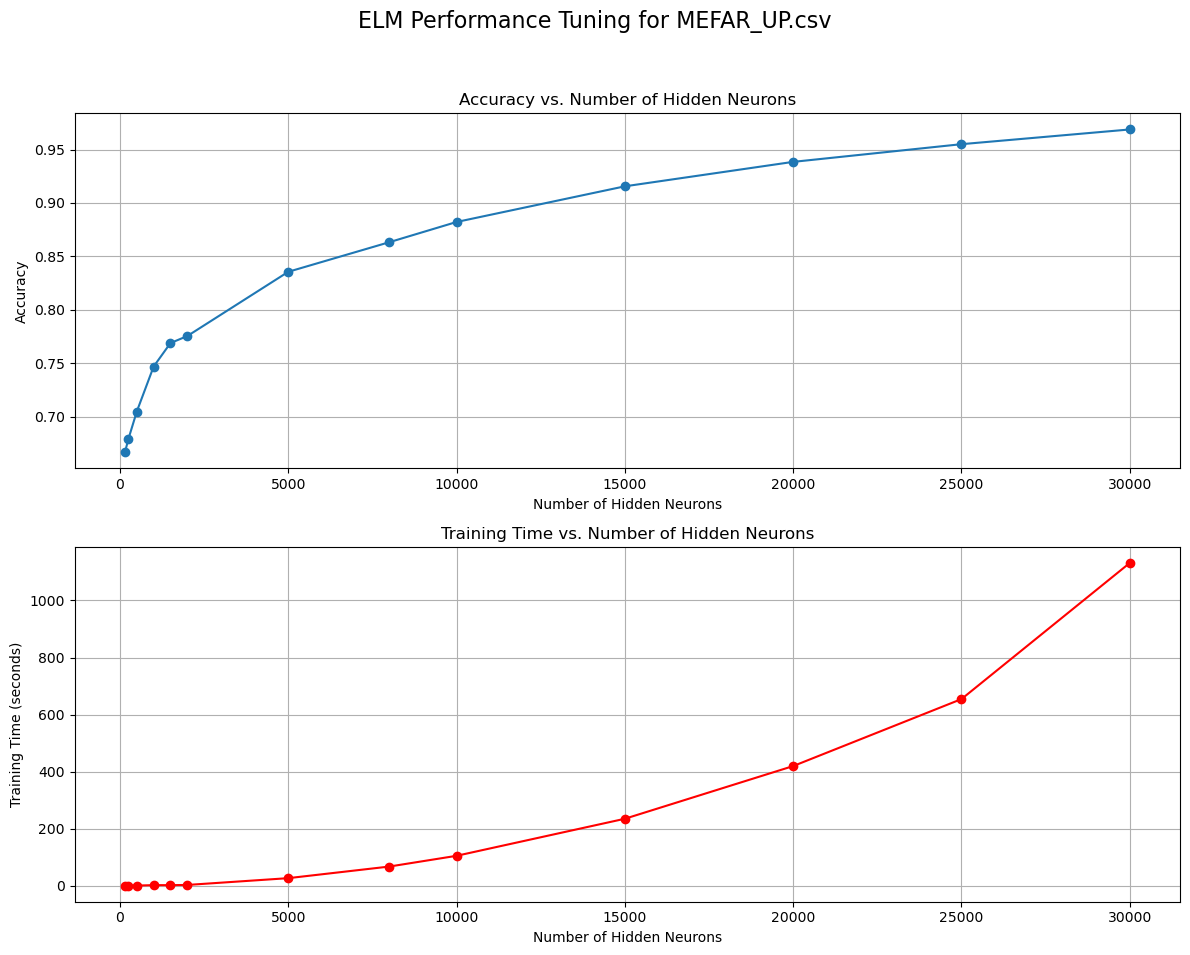

--- Finished Tuning for MEFAR_UP.csv ---



In [4]:
def tune_and_plot_elm(file_path, neuron_range, device):
    """
    Loads a dataset, tunes the ELM for a range of hidden neurons,
    and plots the performance.
    """
    filename = os.path.basename(file_path)
    print(f"--- Starting Tuning for {filename} ---")

    # 1. Load and prepare data
    df = pd.read_csv(file_path)
    if df.isnull().sum().sum() > 0:
        df.fillna(df.mean(), inplace=True)
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_train_pt = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_train_pt = torch.tensor(y_train, dtype=torch.float32)
    X_test_pt = torch.tensor(X_test_scaled, dtype=torch.float32)

    # 2. Tuning loop
    results = []
    for n_neurons in neuron_range:
        model = ELM(n_hidden_neurons=n_neurons, device=device)
        
        start_time = time.time()
        model.fit(X_train_pt, y_train_pt)
        training_time = time.time() - start_time
        
        predictions = model.predict(X_test_pt)
        accuracy = accuracy_score(y_test, predictions.cpu().numpy())
        
        results.append({'neurons': n_neurons, 'accuracy': accuracy, 'training_time': training_time})
        print(f"  Neurons: {n_neurons:5d} | Accuracy: {accuracy*100:6.2f}% | Time: {training_time:.2f}s")
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    # 3. Plotting results
    df_results = pd.DataFrame(results)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    fig.suptitle(f'ELM Performance Tuning for {filename}', fontsize=16)

    # Plot 1: Neurons vs. Accuracy
    ax1.plot(df_results['neurons'], df_results['accuracy'], marker='o', linestyle='-')
    ax1.set_title('Accuracy vs. Number of Hidden Neurons')
    ax1.set_xlabel('Number of Hidden Neurons')
    ax1.set_ylabel('Accuracy')
    ax1.grid(True)

    # Plot 2: Neurons vs. Training Time
    ax2.plot(df_results['neurons'], df_results['training_time'], marker='o', linestyle='-', color='r')
    ax2.set_title('Training Time vs. Number of Hidden Neurons')
    ax2.set_xlabel('Number of Hidden Neurons')
    ax2.set_ylabel('Training Time (seconds)')
    ax2.grid(True)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    print(f"--- Finished Tuning for {filename} ---\n")


# --- Main Script ---
DATASET_PATH = '../Datasets'
dataset_files = [os.path.join(DATASET_PATH, f) for f in os.listdir(DATASET_PATH)]

# Define the expanded range of neurons to test
neuron_counts = [150, 250, 500, 1000, 1500, 2000, 5000, 8000, 10000, 15000, 20000, 25000, 30000]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Master script started. Using device: {device}\n")

# Loop through each dataset and run the tuning function
for file in dataset_files:
    tune_and_plot_elm(file_path=file, neuron_range=neuron_counts, device=device)
